# Predicting flight delays

1. Exploratory Data Analysis (EDA)

In [1]:
# Import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
plt.style.use('ggplot')
%matplotlib inline


In [2]:
flights = pd.read_csv('/Users/ArielYan/Downloads/flight-delays/flights.csv', low_memory=False)
airlines = pd.read_csv('/Users/ArielYan/Downloads/flight-delays/airlines.csv', low_memory=False)
airports = pd.read_csv('/Users/ArielYan/Downloads/flight-delays/airports.csv', low_memory=False)
print('Flights Dataframe dimensions:', flights.shape)
print('Airlines Dataframe dimensions:', airlines.shape)
print('Airports Dataframe dimensions:', airports.shape)

Flights Dataframe dimensions: (5819079, 31)
Airlines Dataframe dimensions: (14, 2)
Airports Dataframe dimensions: (322, 7)


In [3]:
print (flights['FLIGHT_NUMBER'].nunique())

6952


In [4]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [6]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


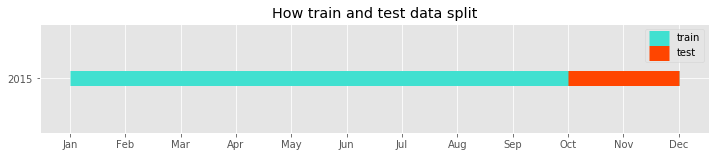

In [7]:
#Train and test data split
fig, ax = plt.subplots(figsize=(12,2));
l1 = plt.hlines(2015, 1, 12, color = 'turquoise', lw=15, label = 'train');
l2=plt.hlines(2015, 10 , 12, color = 'orangered', lw=15, label = 'test');
plt.xticks(np.arange(1,13), ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'));
plt.yticks([2015]);
plt.legend(prop={'size': 10});
plt.title('How train and test data split');


In [8]:
#As the size of dataset is large, so I will only keep the flights from Jan 2015
df = flights[flights['MONTH'] == 1]

Cleaning

In [9]:
#convert the dates and time into one cell named "DATE"
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

/Users/ArielYan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
#merge the take-off hour with the flight date 
#------------------------------------------------
#Function that convert the "HHMM" to datetime.time (HH:MM)
def format_time(time2):
    if pd.isnull(time2):
        return np.nan
    else:
        if time2 == 2400: 
            time2 = 0
            #change to 24 hour format
            #{0:04d}, convert to 4 digit 
        time2 = "{0:04d}".format(int(time2))
        time = datetime.time(int(time2[0:2]), int(time2[2:4]))
        return time
#------------------------------------------------
#Function that combines a date and time to produce a datetime.datetime
def combine_date_time(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#------------------------------------------------
#Function that combine two columns 
def create_flight_time(df, col):
    liste = []
    #iterrows = the number of loop  
    #cols[0] = 'DATE' in df[['DATE', col]]
    #cols[1] ='col'n df[['DATE', col]]
    for index, cols in df[['DATE', col]].iterrows():
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) ==2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_time(cols))
        else:
            cols[1] = format_time(cols[1])
            liste.append(combine_date_time(cols))
    return pd.Series(liste)
#Series = panda list

In [11]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_time)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_time)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_time)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

/Users/ArielYan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ArielYan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ArielYan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [12]:
#Filter out no use column
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

/Users/ArielYan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


Comparing airlines

In [13]:
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


The punctuality of each airline

In [14]:
#extract stat 
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#------------------------------------------------
#Create a new dataframe
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats= global_stats.sort_values('count')
global_stats


,count,max,mean,min
AIRLINE,,,,
VX,4651.0,397.0,6.910772,-20.0
HA,6418.0,1003.0,1.310065,-26.0
F9,6745.0,696.0,17.984433,-32.0
NK,8647.0,557.0,13.146294,-28.0
AS,13198.0,538.0,3.178209,-47.0
B6,20531.0,500.0,10.035556,-27.0
MQ,27670.0,780.0,16.081207,-29.0
US,32552.0,638.0,5.197315,-26.0
UA,37454.0,886.0,14.010359,-40.0


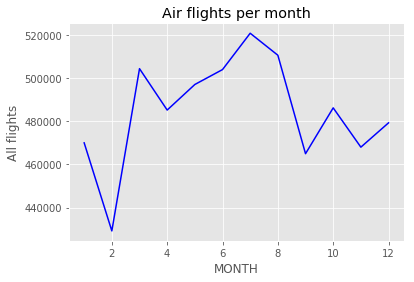

In [15]:
# Time series of the total number of flights for each month
df_1 = flights.groupby('MONTH')['MONTH'].count()
ax = plt.gca()

df_1.plot(kind='line',x='flights.MONTH',y='FLIGHT_NUMBER', color='blue', ax=ax)
ax.set_ylabel('All flights');
plt.title('Air flights per month');
plt.show()
#plt.savefig('1.png')

/Users/ArielYan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


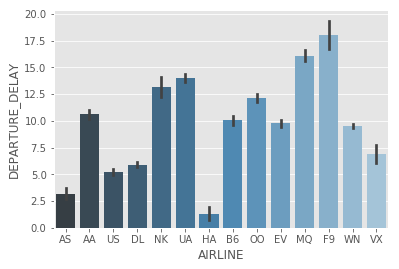

In [16]:
# Barchart of the departure delay time (mins) of each airline

ax = sns.barplot(y='DEPARTURE_DELAY', x='AIRLINE', data=df, palette="Blues_d");
ax

In [17]:
abbr_companies = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()
abbr_companies

{'UA': 'United Air Lines Inc.',
 'AA': 'American Airlines Inc.',
 'US': 'US Airways Inc.',
 'F9': 'Frontier Airlines Inc.',
 'B6': 'JetBlue Airways',
 'OO': 'Skywest Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'WN': 'Southwest Airlines Co.',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'HA': 'Hawaiian Airlines Inc.',
 'MQ': 'American Eagle Airlines Inc.',
 'VX': 'Virgin America'}

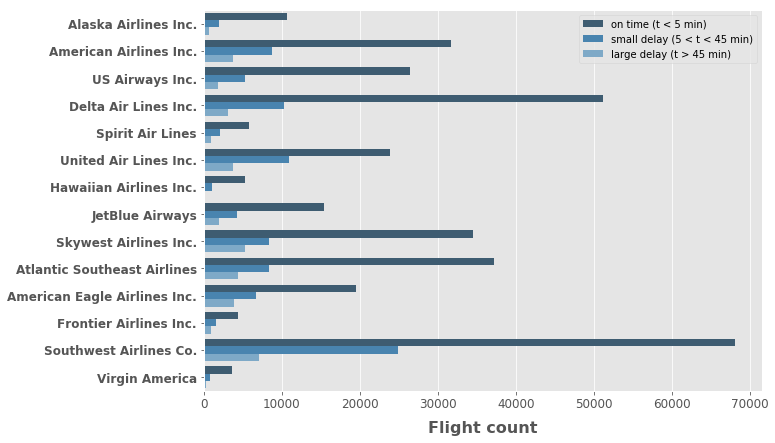

In [18]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df,palette="Blues_d")
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

Modeling

In [19]:
data = flights
data = data.sample(frac = 0.01, random_state=76492)

data = data[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT","AIR_TIME", "DEPARTURE_TIME","DISTANCE","ARRIVAL_DELAY"]]
data.dropna(inplace=True)

data["ARRIVAL_DELAY"] = (data["ARRIVAL_DELAY"]>10)*1

cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]

for item in cols:
    data[item] = data[item].astype("category").cat.codes +1
 
train, test, y_train, y_test = train_test_split(data.drop(["ARRIVAL_DELAY"], axis=1), data["ARRIVAL_DELAY"],
                                                random_state=10, test_size=0.4)

In [20]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(train["AIRLINE"].values.reshape(-1, 1))  

enc.feature_indices_
airline_onehot = enc.transform(train["AIRLINE"].values.reshape(-1, 1)).toarray()
airline_onehot_test = enc.transform(test["AIRLINE"].values.reshape(-1, 1)).toarray()

/Users/ArielYan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/ArielYan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function feature_indices_ is deprecated; The ``feature_indices_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


In [21]:
air_oh_df = pd.DataFrame(airline_onehot, columns = ["A1","A2","A3","A4","A5","A6","A7",
                                                    "A8","A9","A10","A11","A12","A13","A14"])
air_oh_test_df = pd.DataFrame(airline_onehot_test, columns = ["A1","A2","A3","A4","A5","A6","A7",
                                                         "A8","A9","A10","A11","A12","A13","A14"])



In [22]:
train2 = pd.concat([train.reset_index(),air_oh_df.reset_index()],axis=1).drop(["index","MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"],axis=1)
test2  = pd.concat([test.reset_index(),air_oh_test_df.reset_index()],axis=1).drop(["index","MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"],axis=1)

test2

,AIR_TIME,DEPARTURE_TIME,DISTANCE,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,179.0,1456.0,1379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,35.0,1801.0,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,65.0,2022.0,387,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,149.0,1140.0,1190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,122.0,1215.0,813,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,45.0,2230.0,270,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,286.0,822.0,2611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,154.0,2216.0,1171,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,238.0,1525.0,1855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,125.0,2013.0,862,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1. XGBoost

In [ ]:
# showing the performance of a classification model for binary
def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
            metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))
# Parameter Tuning
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
             "n_estimators": [200],
              "learning_rate": [0.05,0.1,0.16]}

In [ ]:
model = xgb.XGBClassifier()

grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                        verbose=10, n_jobs=-1)
grid_search.fit(train, y_train)

grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 11.2min


In [ ]:
start_time = time.time()

model = xgb.XGBClassifier(max_depth=50, min_child_weight=1,  n_estimators=200,
                          n_jobs=-1 , verbose=1, learning_rate=0.16)
model.fit(train2, y_train)

print(auc(model, train2, test2))

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)